<a href="https://colab.research.google.com/github/sabeesh90/Layer_Fine_Tuning_Deep_Neural_Networks/blob/main/The_Lazarus_Trials_Resnet50_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 96 kB 3.5 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
pip install Ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
classes = ['GALAXY', 'QSO', 'STAR']

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#### Resnet 50

##### Data preparation

In [ ]:
# Preprocessing the data
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 8


img_width_crop = 1024
img_height_crop = 1024

rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])


# augmenting the data
# cropless flip and rotate

data_aug_flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                # layers.experimental.preprocessing.RandomRotation(0.2)])
])

data_aug_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2)])


# crop flip and rotate
data_aug_crop_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                                 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                 layers.experimental.preprocessing.RandomRotation(0.2)])

data_aug_crop_flip = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

normal_crop = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512)],)
batch_size =32 
autotune = tf.data.AUTOTUNE

# Preparing the normal dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width_crop, img_height_crop), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width_crop, img_height_crop),
                                                                batch_size = batch_size, label_mode = 'categorical')


# preparing the scalred dataset
train_ds_scaled = train_ds.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled = val_ds.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)
train_ds.prefetch(buffer_size=autotune)
val_ds.prefetch(buffer_size=autotune)

train_ds_scaled_cropped = train_ds_scaled.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled_cropped = val_ds_scaled.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)

# augment function 
def prepare_dataset(ds, flip = False, flip_rotate = False):
    if flip == True:
        ds = ds.map(lambda x, y : (data_aug_flip(x, training = True), y), num_parallel_calls = autotune)
    elif flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)

def prepare_dataset_crop(ds, crop_flip = False, crop_flip_rotate = False):
    if crop_flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    elif crop_flip == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)
    
def prepare_dataset_normal_crop(ds, training = True):
    ds = ds.map(lambda x, y : (normal_crop(x, training = training), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
# 25 batches of 32 each and 7 batches of 32 each



Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


##### Resnet model building

In [ ]:
from tensorflow.keras.applications import  ResNet50
models = {'base_model'+str(num) : ResNet50(include_top=False, weights='imagenet', 
                                           input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg') for num in range(0,10)}

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
models

{'base_model0': <keras.engine.functional.Functional at 0x7f8787628110>,
 'base_model1': <keras.engine.functional.Functional at 0x7f8786efb890>,
 'base_model2': <keras.engine.functional.Functional at 0x7f8786d1b090>,
 'base_model3': <keras.engine.functional.Functional at 0x7f8786cce610>,
 'base_model4': <keras.engine.functional.Functional at 0x7f878671aa90>,
 'base_model5': <keras.engine.functional.Functional at 0x7f87864e71d0>,
 'base_model6': <keras.engine.functional.Functional at 0x7f87864df450>,
 'base_model7': <keras.engine.functional.Functional at 0x7f8786203dd0>,
 'base_model8': <keras.engine.functional.Functional at 0x7f8747f2ae50>,
 'base_model9': <keras.engine.functional.Functional at 0x7f87479dbb50>}

In [ ]:
layer_count  = len(models['base_model0'].layers)
print(f'There are a total of {layer_count} in the resnet layer')

There are a total of 176 in the resnet layer


In [ ]:
for model,value in models.items():
    print(model)

base_model0
base_model1
base_model2
base_model3
base_model4
base_model5
base_model6
base_model7
base_model8
base_model9


In [ ]:
num=0
for i, (model_name, model) in zip(range(176, -1,-5), models.items()):
    break_point  = i
    for layer in model.layers[0:break_point]:
        layer.trainable = False
    for layer in model.layers[break_point:]:
        layer.trainable = True
    input_layer = model.input
    output_layer = model.output
    x = Dense(num_classes, activation  = 'softmax')(output_layer)    
    models[model_name] = Model(inputs = input_layer, outputs = x)


In [ ]:
for model_name, model in models.items():
    count = 0
    trained_layers = ['a' if layer.trainable == True else None for layer in model.layers]
    print(f'The number of trainable layers in {model_name} is', trained_layers.count('a'), sep=':')

The number of trainable layers in base_model0 is:1
The number of trainable layers in base_model1 is:6
The number of trainable layers in base_model2 is:11
The number of trainable layers in base_model3 is:16
The number of trainable layers in base_model4 is:21
The number of trainable layers in base_model5 is:26
The number of trainable layers in base_model6 is:31
The number of trainable layers in base_model7 is:36
The number of trainable layers in base_model8 is:41
The number of trainable layers in base_model9 is:46


In [ ]:
# resnet_model.summary()
for model_name, model in models.items():
    model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
i=0
for model_name, model in models.items():
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('base_model'+str(i),trainableParams,nonTrainableParams,totalParams)
    i+=1


base_model0 6147 23587712 23593859
base_model1 1060867 22532992 23593859
base_model2 3422723 20171136 23593859
base_model3 5526531 18067328 23593859
base_model4 7888387 15705472 23593859
base_model5 8945667 14648192 23593859
base_model6 14456323 9137536 23593859
base_model7 14982147 8611712 23593859
base_model8 15837955 7755904 23593859
base_model9 16100867 7492992 23593859


##### Resnet model with normalization of  image pixels

In [ ]:
models['base_model0'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 21s 709ms/step - loss: 1.7098 - accuracy: 0.4475 - val_loss: 1.1169 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 19s 695ms/step - loss: 1.6058 - accuracy: 0.3800 - val_loss: 1.1005 - val_accuracy: 0.4350
Epoch 3/60
25/25 [==============================] - 18s 674ms/step - loss: 1.6017 - accuracy: 0.2962 - val_loss: 1.0578 - val_accuracy: 0.4350
Epoch 4/60
25/25 [==============================] - 18s 660ms/step - loss: 1.6011 - accuracy: 0.4663 - val_loss: 1.0884 - val_accuracy: 0.4350
Epoch 5/60
25/25 [==============================] - 18s 664ms/step - loss: 1.6034 - accuracy: 0.4800 - val_loss: 1.0884 - val_accuracy: 0.4350
Epoch 6/60
25/25 [==============================] - 18s 674ms/step - loss: 1.6012 - accuracy: 0.4600 - val_loss: 1.0826 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 18s 675ms/step - loss: 1.6111 - accuracy: 0.4825 - val_loss: 1.1209 - val_accuracy: 0.0850

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr,early_stop])

Epoch 1/30
25/25 [==============================] - 20s 634ms/step - loss: 1.6482 - accuracy: 0.4187 - val_loss: 1.4591 - val_accuracy: 0.4800
Epoch 2/30
25/25 [==============================] - 17s 618ms/step - loss: 1.5923 - accuracy: 0.4825 - val_loss: 1.3490 - val_accuracy: 0.4800
Epoch 3/30
25/25 [==============================] - 17s 621ms/step - loss: 1.5698 - accuracy: 0.4263 - val_loss: 1.3874 - val_accuracy: 0.4800
Epoch 4/30
25/25 [==============================] - 17s 623ms/step - loss: 1.5536 - accuracy: 0.5938 - val_loss: 1.3281 - val_accuracy: 0.4800
Epoch 5/30
25/25 [==============================] - 17s 624ms/step - loss: 1.5408 - accuracy: 0.5213 - val_loss: 1.4799 - val_accuracy: 0.0850
Epoch 6/30
25/25 [==============================] - 17s 629ms/step - loss: 1.5201 - accuracy: 0.5412 - val_loss: 1.4006 - val_accuracy: 0.0850
Epoch 7/30
25/25 [==============================] - 17s 631ms/step - loss: 1.5163 - accuracy: 0.4137 - val_loss: 1.3643 - val_accuracy: 0.0850

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr,early_stop])

Epoch 1/30
25/25 [==============================] - 17s 635ms/step - loss: 1.1526 - accuracy: 0.8400 - val_loss: 0.7824 - val_accuracy: 0.8400
Epoch 2/30
25/25 [==============================] - 17s 635ms/step - loss: 1.1334 - accuracy: 0.8325 - val_loss: 0.9028 - val_accuracy: 0.4550
Epoch 3/30
25/25 [==============================] - 17s 639ms/step - loss: 1.1389 - accuracy: 0.8062 - val_loss: 0.7661 - val_accuracy: 0.7650
Epoch 4/30
25/25 [==============================] - 17s 637ms/step - loss: 1.1299 - accuracy: 0.8325 - val_loss: 0.8387 - val_accuracy: 0.5500
Epoch 5/30
25/25 [==============================] - 17s 640ms/step - loss: 1.1378 - accuracy: 0.8450 - val_loss: 0.8125 - val_accuracy: 0.7550
Epoch 6/30
25/25 [==============================] - 17s 639ms/step - loss: 1.1274 - accuracy: 0.8000 - val_loss: 0.7921 - val_accuracy: 0.7500
Epoch 7/30
25/25 [==============================] - 17s 643ms/step - loss: 1.1329 - accuracy: 0.8438 - val_loss: 0.7261 - val_accuracy: 0.7850

In [ ]:
models['base_model2'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 20s 734ms/step - loss: 1.5441 - accuracy: 0.8238 - val_loss: 1.1995 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 19s 709ms/step - loss: 1.5365 - accuracy: 0.8050 - val_loss: 1.1630 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 18s 684ms/step - loss: 1.5335 - accuracy: 0.8150 - val_loss: 1.1466 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 18s 687ms/step - loss: 1.5300 - accuracy: 0.8037 - val_loss: 1.1329 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 19s 699ms/step - loss: 1.5279 - accuracy: 0.8213 - val_loss: 1.1160 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 19s 708ms/step - loss: 1.5249 - accuracy: 0.8325 - val_loss: 1.0976 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 19s 700ms/step - loss: 1.5237 - accuracy: 0.8213 - val_loss: 1.0800 - val_accuracy: 0.4800

In [ ]:
models['base_model3'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 23s 751ms/step - loss: 1.6418 - accuracy: 0.4050 - val_loss: 1.8373 - val_accuracy: 0.0850
Epoch 2/60
25/25 [==============================] - 20s 747ms/step - loss: 1.2255 - accuracy: 0.5950 - val_loss: 1.3619 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 19s 729ms/step - loss: 1.0664 - accuracy: 0.7287 - val_loss: 1.9477 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 19s 717ms/step - loss: 0.9407 - accuracy: 0.7513 - val_loss: 0.8697 - val_accuracy: 0.4950
Epoch 5/60
25/25 [==============================] - 19s 721ms/step - loss: 0.8422 - accuracy: 0.7487 - val_loss: 1.8770 - val_accuracy: 0.4350
Epoch 6/60
25/25 [==============================] - 19s 729ms/step - loss: 0.7796 - accuracy: 0.8200 - val_loss: 1.5635 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 19s 724ms/step - loss: 0.7169 - accuracy: 0.8350 - val_loss: 0.9349 - val_accuracy: 0.4350

In [ ]:
models['base_model4'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 23s 769ms/step - loss: 1.6067 - accuracy: 0.4737 - val_loss: 1.6996 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 20s 732ms/step - loss: 1.1349 - accuracy: 0.7063 - val_loss: 2.0442 - val_accuracy: 0.4350
Epoch 3/60
25/25 [==============================] - 20s 767ms/step - loss: 0.9587 - accuracy: 0.7513 - val_loss: 1.0266 - val_accuracy: 0.4350
Epoch 4/60
25/25 [==============================] - 20s 750ms/step - loss: 0.8953 - accuracy: 0.7550 - val_loss: 1.7439 - val_accuracy: 0.4350
Epoch 5/60
25/25 [==============================] - 19s 725ms/step - loss: 0.7664 - accuracy: 0.8175 - val_loss: 1.2315 - val_accuracy: 0.5550
Epoch 6/60
25/25 [==============================] - 20s 734ms/step - loss: 0.7772 - accuracy: 0.7987 - val_loss: 2.0274 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 20s 744ms/step - loss: 0.6502 - accuracy: 0.8288 - val_loss: 1.1391 - val_accuracy: 0.6800

In [ ]:
models['base_model5'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 71s 1s/step - loss: 1.8265 - accuracy: 0.3388 - val_loss: 1.3350 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 11s 388ms/step - loss: 1.6533 - accuracy: 0.3338 - val_loss: 1.1514 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 11s 388ms/step - loss: 1.5833 - accuracy: 0.4162 - val_loss: 1.0694 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 11s 388ms/step - loss: 1.1641 - accuracy: 0.7500 - val_loss: 1.2644 - val_accuracy: 0.4350
Epoch 5/60
25/25 [==============================] - 11s 389ms/step - loss: 0.9826 - accuracy: 0.7050 - val_loss: 2.4349 - val_accuracy: 0.4350
Epoch 6/60
25/25 [==============================] - 11s 389ms/step - loss: 0.8395 - accuracy: 0.8050 - val_loss: 4.4705 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 11s 388ms/step - loss: 0.7253 - accuracy: 0.8263 - val_loss: 6.5502 - val_accuracy: 0.4350
Ep

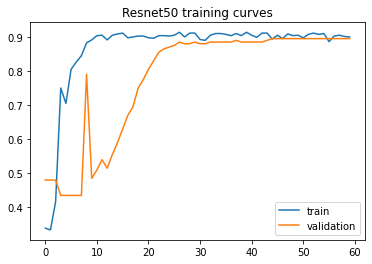

In [ ]:
plt.plot(models['base_model5'].history.history['accuracy'])
plt.plot(models['base_model5'].history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('Resnet50 training curves')
plt.show()

In [ ]:
models['base_model5'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 24s 787ms/step - loss: 1.6893 - accuracy: 0.3450 - val_loss: 0.9436 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 20s 765ms/step - loss: 1.2261 - accuracy: 0.6575 - val_loss: 1.5894 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 20s 756ms/step - loss: 0.8975 - accuracy: 0.7025 - val_loss: 0.9778 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 20s 751ms/step - loss: 0.7850 - accuracy: 0.8238 - val_loss: 1.2230 - val_accuracy: 0.4350
Epoch 5/60
25/25 [==============================] - 20s 754ms/step - loss: 0.7191 - accuracy: 0.8288 - val_loss: 2.4836 - val_accuracy: 0.4350
Epoch 6/60
25/25 [==============================] - 20s 759ms/step - loss: 0.5826 - accuracy: 0.8562 - val_loss: 2.7180 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 20s 757ms/step - loss: 0.5259 - accuracy: 0.8650 - val_loss: 1.4585 - val_accuracy: 0.4350

In [ ]:
models['base_model6'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 25s 820ms/step - loss: 1.7243 - accuracy: 0.3262 - val_loss: 1.6910 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 21s 804ms/step - loss: 1.7212 - accuracy: 0.3537 - val_loss: 1.4927 - val_accuracy: 0.4350
Epoch 3/60
25/25 [==============================] - 21s 805ms/step - loss: 1.3152 - accuracy: 0.6575 - val_loss: 2.1140 - val_accuracy: 0.0850
Epoch 4/60
25/25 [==============================] - 21s 783ms/step - loss: 1.0886 - accuracy: 0.6500 - val_loss: 2.0173 - val_accuracy: 0.4350
Epoch 5/60
25/25 [==============================] - 21s 779ms/step - loss: 0.9491 - accuracy: 0.7337 - val_loss: 3.8571 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 21s 789ms/step - loss: 0.7717 - accuracy: 0.8050 - val_loss: 13.3604 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 21s 797ms/step - loss: 0.7056 - accuracy: 0.8300 - val_loss: 12.8480 - val_accuracy: 0.48

In [ ]:
models['base_model7'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 25s 827ms/step - loss: 1.7186 - accuracy: 0.4187 - val_loss: 1.3673 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 21s 804ms/step - loss: 1.6733 - accuracy: 0.3400 - val_loss: 1.3989 - val_accuracy: 0.4350
Epoch 3/60
25/25 [==============================] - 21s 797ms/step - loss: 1.5956 - accuracy: 0.4288 - val_loss: 2.1989 - val_accuracy: 0.4350
Epoch 4/60
25/25 [==============================] - 21s 796ms/step - loss: 1.0582 - accuracy: 0.6550 - val_loss: 1.2600 - val_accuracy: 0.4350
Epoch 5/60
25/25 [==============================] - 21s 796ms/step - loss: 0.9546 - accuracy: 0.7663 - val_loss: 4.5391 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 21s 799ms/step - loss: 0.9253 - accuracy: 0.7588 - val_loss: 4.3335 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 21s 788ms/step - loss: 0.7499 - accuracy: 0.8100 - val_loss: 4.2061 - val_accuracy: 0.4800

In [ ]:
models['base_model8'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 26s 872ms/step - loss: 1.8133 - accuracy: 0.3225 - val_loss: 1.4944 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 22s 844ms/step - loss: 1.5045 - accuracy: 0.5113 - val_loss: 2.4711 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 22s 839ms/step - loss: 1.0813 - accuracy: 0.6587 - val_loss: 4.4346 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 22s 837ms/step - loss: 0.9991 - accuracy: 0.6825 - val_loss: 7.4850 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 22s 841ms/step - loss: 0.9265 - accuracy: 0.7487 - val_loss: 6.9022 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 22s 843ms/step - loss: 0.8079 - accuracy: 0.7663 - val_loss: 3.0360 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 22s 841ms/step - loss: 0.6603 - accuracy: 0.8100 - val_loss: 3.2307 - val_accuracy: 0.4350

In [ ]:
models['base_model9'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 26s 846ms/step - loss: 1.6887 - accuracy: 0.3913 - val_loss: 1.2466 - val_accuracy: 0.0850
Epoch 2/60
25/25 [==============================] - 22s 828ms/step - loss: 1.2700 - accuracy: 0.6425 - val_loss: 1.3263 - val_accuracy: 0.0850
Epoch 3/60
25/25 [==============================] - 22s 831ms/step - loss: 1.1764 - accuracy: 0.6263 - val_loss: 1.9645 - val_accuracy: 0.0850
Epoch 4/60
25/25 [==============================] - 22s 833ms/step - loss: 0.9656 - accuracy: 0.7287 - val_loss: 1.7612 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 22s 836ms/step - loss: 0.9767 - accuracy: 0.7337 - val_loss: 1.8396 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 21s 804ms/step - loss: 0.8373 - accuracy: 0.8050 - val_loss: 6.1869 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 22s 813ms/step - loss: 0.7033 - accuracy: 0.8462 - val_loss: 6.2747 - val_accuracy: 0.4800

In [ ]:
base_resnet= ResNet50(include_top=False, weights='imagenet',input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg')
for layer in base_resnet.layers:
    layer.trainable = True
input_layer = base_resnet.input
output_layer = base_resnet.output
x = Dense(num_classes, activation  = 'softmax')(output_layer)    
base_resnet_retrained = Model(inputs = input_layer, outputs = x)

trained_layers = ['a' if layer.trainable == True else None for layer in base_resnet_retrained.layers]
print(f'The number of trainable layers in base_resnet_retrained is', trained_layers.count('a'), sep=':')

The number of trainable layers in base_resnet_retrained is:177


In [ ]:
base_resnet_retrained.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
base_resnet_retrained.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60


ResourceExhaustedError: ignored